In [1]:
import findspark

In [2]:
findspark.init()
findspark.find()

'C:\\spark\\spark-3.4.3-bin-hadoop3'

In [3]:
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")

In [4]:
spark = SparkSession.builder \
    .appName("HDFS File Access") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

In [5]:
# Reading medical precription data from hdfs into a spark dataframe 
mp_df = spark.read.csv("hdfs://localhost:9000/datasets/medical_prescription.csv",header=True,inferSchema=True)

In [6]:
# Reading general payments data from hdfs into a spark dataframe
gp_df = spark.read.csv("hdfs://localhost:9000/datasets/general_payments.csv",header=True,inferSchema=True)

In [205]:
mp_df.dtypes

[('Prscrbr_NPI', 'int'),
 ('Prscrbr_Last_Org_Name', 'string'),
 ('Prscrbr_First_Name', 'string'),
 ('Prscrbr_City', 'string'),
 ('Prscrbr_State_Abrvtn', 'string'),
 ('Prscrbr_State_FIPS', 'string'),
 ('Prscrbr_Type', 'string'),
 ('Prscrbr_Type_Src', 'string'),
 ('Brnd_Name', 'string'),
 ('Gnrc_Name', 'string'),
 ('Tot_Clms', 'int'),
 ('Tot_30day_Fills', 'double'),
 ('Tot_Day_Suply', 'int'),
 ('Tot_Drug_Cst', 'double'),
 ('Tot_Benes', 'int'),
 ('GE65_Sprsn_Flag', 'string'),
 ('GE65_Tot_Clms', 'int'),
 ('GE65_Tot_30day_Fills', 'double'),
 ('GE65_Tot_Drug_Cst', 'double'),
 ('GE65_Tot_Day_Suply', 'int'),
 ('GE65_Bene_Sprsn_Flag', 'string'),
 ('GE65_Tot_Benes', 'int')]

In [207]:
gp_df.dtypes

[('Change_Type', 'string'),
 ('Covered_Recipient_Type', 'string'),
 ('Teaching_Hospital_CCN', 'int'),
 ('Teaching_Hospital_ID', 'int'),
 ('Teaching_Hospital_Name', 'string'),
 ('Covered_Recipient_Profile_ID', 'int'),
 ('Covered_Recipient_NPI', 'int'),
 ('Covered_Recipient_First_Name', 'string'),
 ('Covered_Recipient_Middle_Name', 'string'),
 ('Covered_Recipient_Last_Name', 'string'),
 ('Covered_Recipient_Name_Suffix', 'string'),
 ('Recipient_Primary_Business_Street_Address_Line1', 'string'),
 ('Recipient_Primary_Business_Street_Address_Line2', 'string'),
 ('Recipient_City', 'string'),
 ('Recipient_State', 'string'),
 ('Recipient_Zip_Code', 'string'),
 ('Recipient_Country', 'string'),
 ('Recipient_Province', 'string'),
 ('Recipient_Postal_Code', 'string'),
 ('Covered_Recipient_Primary_Type_1', 'string'),
 ('Covered_Recipient_Primary_Type_2', 'string'),
 ('Covered_Recipient_Primary_Type_3', 'string'),
 ('Covered_Recipient_Primary_Type_4', 'string'),
 ('Covered_Recipient_Primary_Type_5', 

## Data Cleaning for Medical Prescription data

In [9]:
# importing neccessary functions
from pyspark.sql.functions import col,isnan,when,count,expr,percentile_approx,median
from pyspark.sql import functions as F

In [10]:
total_count = mp_df.count()

In [11]:
total_count

25869521

In [12]:
# Finding null value percentage for all columns in the dataset
null_perc = mp_df.select([(count(when(col(c).isNull() | isnan(c), c)) / total_count).alias(c) for c in mp_df.columns]).collect()
null_perc_list = [(c, round(row[c]*100,2)) for row in null_perc for c in mp_df.columns]
sorted(null_perc_list, key=lambda x: x[1], reverse=True) # sorting to show null percentages in descending order

[('GE65_Tot_Benes', 88.91),
 ('Tot_Benes', 56.08),
 ('GE65_Sprsn_Flag', 55.06),
 ('GE65_Tot_Clms', 44.94),
 ('GE65_Tot_30day_Fills', 44.94),
 ('GE65_Tot_Drug_Cst', 44.94),
 ('GE65_Tot_Day_Suply', 44.94),
 ('GE65_Bene_Sprsn_Flag', 11.09),
 ('Prscrbr_NPI', 0.0),
 ('Prscrbr_Last_Org_Name', 0.0),
 ('Prscrbr_First_Name', 0.0),
 ('Prscrbr_City', 0.0),
 ('Prscrbr_State_Abrvtn', 0.0),
 ('Prscrbr_State_FIPS', 0.0),
 ('Prscrbr_Type', 0.0),
 ('Prscrbr_Type_Src', 0.0),
 ('Brnd_Name', 0.0),
 ('Gnrc_Name', 0.0),
 ('Tot_Clms', 0.0),
 ('Tot_30day_Fills', 0.0),
 ('Tot_Day_Suply', 0.0),
 ('Tot_Drug_Cst', 0.0)]

In [13]:
# Checking values in GE65_Bene_Sprsn_Flag
mp_df.groupBy('GE65_Bene_Sprsn_Flag').agg(F.count('*').alias('count'),F.round((F.count('*') / total_count * 100),2).alias('percentage') ).orderBy('count', ascending=False).show()

+--------------------+--------+----------+
|GE65_Bene_Sprsn_Flag|   count|percentage|
+--------------------+--------+----------+
|                   *|15553062|     60.12|
|                   #| 7447012|     28.79|
|                null| 2869447|     11.09|
+--------------------+--------+----------+



In [14]:
# Retrieving list of columns with less than 40% null values
non_null_cols = [x for x,y in null_perc_list if y <= 40]
non_null_cols.remove('GE65_Bene_Sprsn_Flag') # removing the column GE65_Bene_Sprsn_Flag since all columns the flag corresponds to have been removed due to higher null value count.
non_null_cols += ['Tot_Benes'] # adding this column to the list because the null values are left blank purposefully for any value <11.
non_null_cols

['Prscrbr_NPI',
 'Prscrbr_Last_Org_Name',
 'Prscrbr_First_Name',
 'Prscrbr_City',
 'Prscrbr_State_Abrvtn',
 'Prscrbr_State_FIPS',
 'Prscrbr_Type',
 'Prscrbr_Type_Src',
 'Brnd_Name',
 'Gnrc_Name',
 'Tot_Clms',
 'Tot_30day_Fills',
 'Tot_Day_Suply',
 'Tot_Drug_Cst',
 'Tot_Benes']

In [15]:
#Removing columns with null value percentage over 40% except Total_Benes and removing GE65_Bene_Sprsn_Flag due to unknown values.
mp_df1 = mp_df.select(non_null_cols)

In [16]:
mp_df1.dtypes

[('Prscrbr_NPI', 'int'),
 ('Prscrbr_Last_Org_Name', 'string'),
 ('Prscrbr_First_Name', 'string'),
 ('Prscrbr_City', 'string'),
 ('Prscrbr_State_Abrvtn', 'string'),
 ('Prscrbr_State_FIPS', 'string'),
 ('Prscrbr_Type', 'string'),
 ('Prscrbr_Type_Src', 'string'),
 ('Brnd_Name', 'string'),
 ('Gnrc_Name', 'string'),
 ('Tot_Clms', 'int'),
 ('Tot_30day_Fills', 'double'),
 ('Tot_Day_Suply', 'int'),
 ('Tot_Drug_Cst', 'double'),
 ('Tot_Benes', 'int')]

In [17]:
# Checking for unique values
for column,dtype in mp_df1.dtypes:
    if dtype == 'string':
        print(f"Value counts for column: {column}")
        mp_df1.groupBy(column).agg(F.count('*').alias('count'),F.round((F.count('*') / total_count * 100),2).alias('percentage') ).orderBy('count', ascending=False).show()

Value counts for column: Prscrbr_Last_Org_Name
+---------------------+------+----------+
|Prscrbr_Last_Org_Name| count|percentage|
+---------------------+------+----------+
|                Patel|148699|      0.57|
|                Smith|142360|      0.55|
|              Johnson|103453|       0.4|
|                  Lee| 89306|      0.35|
|               Miller| 84535|      0.33|
|             Williams| 82024|      0.32|
|               Nguyen| 77355|       0.3|
|                Brown| 73651|      0.28|
|                Jones| 71673|      0.28|
|                Davis| 61448|      0.24|
|             Anderson| 55557|      0.21|
|                 Shah| 54820|      0.21|
|                  Kim| 51668|       0.2|
|                 Khan| 51054|       0.2|
|               Thomas| 50746|       0.2|
|               Wilson| 46212|      0.18|
|               Martin| 43689|      0.17|
|                Singh| 43351|      0.17|
|            Rodriguez| 42141|      0.16|
|               Taylor| 41434

In [18]:
# removing "Prscrbr_Type_Src" as the column is biased towards a single value with over 90% of the values being the same.
non_null_cols.remove('Prscrbr_Type_Src')

In [19]:
mp_df1 = mp_df1.select(non_null_cols)
mp_df1.dtypes

[('Prscrbr_NPI', 'int'),
 ('Prscrbr_Last_Org_Name', 'string'),
 ('Prscrbr_First_Name', 'string'),
 ('Prscrbr_City', 'string'),
 ('Prscrbr_State_Abrvtn', 'string'),
 ('Prscrbr_State_FIPS', 'string'),
 ('Prscrbr_Type', 'string'),
 ('Brnd_Name', 'string'),
 ('Gnrc_Name', 'string'),
 ('Tot_Clms', 'int'),
 ('Tot_30day_Fills', 'double'),
 ('Tot_Day_Suply', 'int'),
 ('Tot_Drug_Cst', 'double'),
 ('Tot_Benes', 'int')]

In [23]:
numeric_cols = [x for x,y in mp_df1.dtypes if y != 'string']
numeric_cols.remove('Prscrbr_NPI') # since it is an identifier
numeric_cols

['Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 'Tot_Benes']

In [24]:
percentiles = [0.25,0.5,0.75]
perc_vals = {}
for col_name in numeric_cols:
    perc_vals[col_name] = mp_df1.approxQuantile(col_name, percentiles, 0.01)

for col,val in perc_vals.items():
    print(f'{col}: 25th percentile = {val[0]}, 50th percentile = {val[1]}, 75th percentile = {val[2]}')

Tot_Clms: 25th percentile = 15.0, 50th percentile = 25.0, 75th percentile = 50.0
Tot_30day_Fills: 25th percentile = 22.0, 50th percentile = 40.1, 75th percentile = 88.0
Tot_Day_Suply: 25th percentile = 510.0, 50th percentile = 1103.0, 75th percentile = 2490.0
Tot_Drug_Cst: 25th percentile = 253.08, 50th percentile = 636.77, 75th percentile = 2042.47
Tot_Benes: 25th percentile = 14.0, 50th percentile = 20.0, 75th percentile = 34.0


In [25]:
for col_name,val in perc_vals.items():
    if col_name not in ['Prscrbr_NPI']:
        lower = val[0] - 1.5 * (val[2] - val[0])
        upper = val[2] + 1.5 * (val[2] - val[0])
        print(f'{col_name}: lower_bound = {lower}, upper_bound = {upper}')

Tot_Clms: lower_bound = -37.5, upper_bound = 102.5
Tot_30day_Fills: lower_bound = -77.0, upper_bound = 187.0
Tot_Day_Suply: lower_bound = -2460.0, upper_bound = 5460.0
Tot_Drug_Cst: lower_bound = -2431.005, upper_bound = 4726.555
Tot_Benes: lower_bound = -16.0, upper_bound = 64.0


In [26]:
mp_df1.select(numeric_cols).describe().show()

+-------+------------------+-----------------+------------------+-----------------+-----------------+
|summary|          Tot_Clms|  Tot_30day_Fills|     Tot_Day_Suply|     Tot_Drug_Cst|        Tot_Benes|
+-------+------------------+-----------------+------------------+-----------------+-----------------+
|  count|          25869521|         25869521|          25869521|         25869521|         11362619|
|   mean| 51.32395400749786|94.32606860404812|2666.8088683590236|7080.106426521477|30.92538991230807|
| stddev|120.05501083369062| 194.574257112663| 5249.050779356042|50637.31018307316|96.32806750745658|
|    min|                11|             11.0|                 8|              0.0|               11|
|    max|            228252|         228430.4|            760312|    4.468290608E7|           170281|
+-------+------------------+-----------------+------------------+-----------------+-----------------+



In [31]:
mp_df1 = mp_df1.filter(F.col('Tot_Drug_Cst') <= 4726) # removing records where Tot_Drug_Cst is greater than the upper bound of the IQR

In [32]:
mp_df1.select(numeric_cols).describe().show()

+-------+-----------------+------------------+-----------------+-----------------+-----------------+
|summary|         Tot_Clms|   Tot_30day_Fills|    Tot_Day_Suply|     Tot_Drug_Cst|        Tot_Benes|
+-------+-----------------+------------------+-----------------+-----------------+-----------------+
|  count|         21779068|          21779068|         21779068|         21779068|          9832296|
|   mean|43.81498579278048|  82.2831696012091|2316.227989554007|848.8223249511836|26.95466369197998|
| stddev|54.60278903711289|122.25894119835078|3670.557250985592|945.4379715540107|22.33862267082318|
|    min|               11|              11.0|                8|              0.0|               11|
|    max|             2421|            4096.3|           122889|           4726.0|             1401|
+-------+-----------------+------------------+-----------------+-----------------+-----------------+



In [55]:
mp_df1 = mp_df1.filter(F.col('Tot_Drug_Cst') != 0) # Filtering out records with Drug cost of 0 since that doesn't make sense

In [56]:
mp_df1.count()

21776965

In [57]:
mp_df1.select(numeric_cols).describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+
|summary|         Tot_Clms|   Tot_30day_Fills|     Tot_Day_Suply|     Tot_Drug_Cst|         Tot_Benes|
+-------+-----------------+------------------+------------------+-----------------+------------------+
|  count|         21776965|          21776965|          21776965|         21776965|           9832259|
|   mean|43.81781543020343| 82.28860554720394|2316.3795447161715|848.9042956642455| 26.95469189735543|
| stddev|54.60462923980024|122.26348414279704|3670.6987331196074|945.4468213943493|22.338610026746068|
|    min|               11|              11.0|                 8|             0.01|                11|
|    max|             2421|            4096.3|            122889|           4726.0|              1401|
+-------+-----------------+------------------+------------------+-----------------+------------------+



In [62]:
mp_df_final = mp_df1

## Data Cleaning for General Payment data

In [35]:
total_count = gp_df.count()

In [36]:
total_count

13286470

In [37]:
# Finding null value percentage for all columns in the dataset
null_perc = gp_df.select([(count(when(F.col(c).isNull() | isnan(c), c)) / total_count).alias(c) for c in gp_df.columns]).collect()
null_perc_list = [(c, round(row[c]*100,2)) for row in null_perc for c in gp_df.columns]
sorted(null_perc_list, key=lambda x: x[1], reverse=True) # sorting to show null percentages in descending order

[('Recipient_Province', 100.0),
 ('Recipient_Postal_Code', 100.0),
 ('Covered_Recipient_Specialty_2', 100.0),
 ('Covered_Recipient_Specialty_3', 100.0),
 ('Covered_Recipient_Specialty_4', 100.0),
 ('Covered_Recipient_Specialty_5', 100.0),
 ('Covered_Recipient_Specialty_6', 100.0),
 ('Covered_Recipient_Primary_Type_3', 99.99),
 ('Covered_Recipient_Primary_Type_4', 99.99),
 ('Covered_Recipient_Primary_Type_5', 99.99),
 ('Covered_Recipient_Primary_Type_6', 99.99),
 ('Covered_Recipient_Primary_Type_2', 99.98),
 ('Covered_Recipient_License_State_code5', 99.97),
 ('Covered_Recipient_License_State_code4', 99.88),
 ('Associated_Device_or_Medical_Supply_PDI_5', 99.73),
 ('Teaching_Hospital_CCN', 99.71),
 ('Teaching_Hospital_ID', 99.71),
 ('Teaching_Hospital_Name', 99.71),
 ('Associated_Device_or_Medical_Supply_PDI_4', 99.64),
 ('Covered_Recipient_License_State_code3', 99.55),
 ('Associated_Drug_or_Biological_NDC_5', 99.47),
 ('Associated_Device_or_Medical_Supply_PDI_3', 99.38),
 ('Name_of_Third

In [38]:
# Filtering out records that have more that 40% null values
non_null_cols = [x for x,y in null_perc_list if y <= 40]
non_null_cols

['Change_Type',
 'Covered_Recipient_Type',
 'Covered_Recipient_Profile_ID',
 'Covered_Recipient_NPI',
 'Covered_Recipient_First_Name',
 'Covered_Recipient_Last_Name',
 'Recipient_Primary_Business_Street_Address_Line1',
 'Recipient_City',
 'Recipient_State',
 'Recipient_Zip_Code',
 'Recipient_Country',
 'Covered_Recipient_Primary_Type_1',
 'Covered_Recipient_Specialty_1',
 'Covered_Recipient_License_State_code1',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Total_Amount_of_Payment_USDollars',
 'Date_of_Payment',
 'Number_of_Payments_Included_in_Total_Amount',
 'Form_of_Payment_or_Transfer_of_Value',
 'Nature_of_Payment_or_Transfer_of_Value',
 'Physician_Ownership_Indicator',
 'Third_Party_Payment_Recipient_

In [39]:
#Removing columns with null value percentage over 40% except Total_Benes and removing GE65_Bene_Sprsn_Flag due to unknown values.
gp_df1 = gp_df.select(non_null_cols)

In [40]:
gp_df1.dtypes

[('Change_Type', 'string'),
 ('Covered_Recipient_Type', 'string'),
 ('Covered_Recipient_Profile_ID', 'int'),
 ('Covered_Recipient_NPI', 'int'),
 ('Covered_Recipient_First_Name', 'string'),
 ('Covered_Recipient_Last_Name', 'string'),
 ('Recipient_Primary_Business_Street_Address_Line1', 'string'),
 ('Recipient_City', 'string'),
 ('Recipient_State', 'string'),
 ('Recipient_Zip_Code', 'string'),
 ('Recipient_Country', 'string'),
 ('Covered_Recipient_Primary_Type_1', 'string'),
 ('Covered_Recipient_Specialty_1', 'string'),
 ('Covered_Recipient_License_State_code1', 'string'),
 ('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
  'string'),
 ('Total_Amount_of_Payment_USDol

In [102]:
# Checking for unique values
for column,dtype in gp_df1.dtypes:
    if dtype == 'string':
        print(f"Value counts for column: {column}")
        gp_df1.groupBy(column).agg(F.count('*').alias('count'),F.round((F.count('*') / total_count * 100),2).alias('percentage') ).orderBy('count', ascending=False).show()

Value counts for column: Change_Type
+-----------+--------+----------+
|Change_Type|   count|percentage|
+-----------+--------+----------+
|  UNCHANGED|12712116|     95.68|
|    CHANGED|  435391|      3.28|
|        NEW|  135805|      1.02|
|        ADD|    3158|      0.02|
+-----------+--------+----------+

Value counts for column: Covered_Recipient_Type
+----------------------+-------+----------+
|Covered_Recipient_Type|  count|percentage|
+----------------------+-------+----------+
|  Covered Recipient...|9011348|     67.82|
|  Covered Recipient...|4236279|     31.88|
|  Covered Recipient...|  38843|      0.29|
+----------------------+-------+----------+

Value counts for column: Covered_Recipient_First_Name
+----------------------------+------+----------+
|Covered_Recipient_First_Name| count|percentage|
+----------------------------+------+----------+
|                     MICHAEL|227642|      1.71|
|                       DAVID|200915|      1.51|
|                        JOHN|1807

In [41]:
# Retaining collumns that are unbiased and neccessary for analysis
uneccassary_cols = ['Change_Type',
                    'Recipient_Primary_Business_Street_Address_Line1',
                    'Recipient_Zip_Code',
                    'Recipient_Country',
                    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
                    'Number_of_Payments_Included_in_Total_Amount',
                    'Physician_Ownership_Indicator',
                    'Third_Party_Payment_Recipient_Indicator',
                    'Delay_in_Publication_Indicator',
                    'Record_ID',
                    'Dispute_Status_for_Publication',
                    'Related_Product_Indicator',
                    'Program_Year',
                    'Associated_Drug_or_Biological_NDC_1',
                    'Payment_Publication_Date',
                    'Nature_of_Payment_or_Transfer_of_Value',
                    'Form_of_Payment_or_Transfer_of_Value']
for col_name in uneccassary_cols:
    non_null_cols.remove(col_name)
non_null_cols

['Covered_Recipient_Type',
 'Covered_Recipient_Profile_ID',
 'Covered_Recipient_NPI',
 'Covered_Recipient_First_Name',
 'Covered_Recipient_Last_Name',
 'Recipient_City',
 'Recipient_State',
 'Covered_Recipient_Primary_Type_1',
 'Covered_Recipient_Specialty_1',
 'Covered_Recipient_License_State_code1',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Total_Amount_of_Payment_USDollars',
 'Date_of_Payment',
 'Covered_or_Noncovered_Indicator_1',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Product_Category_or_Therapeutic_Area_1',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1']

In [42]:
gp_df1 = gp_df1.select(non_null_cols)
gp_df1.dtypes

[('Covered_Recipient_Type', 'string'),
 ('Covered_Recipient_Profile_ID', 'int'),
 ('Covered_Recipient_NPI', 'int'),
 ('Covered_Recipient_First_Name', 'string'),
 ('Covered_Recipient_Last_Name', 'string'),
 ('Recipient_City', 'string'),
 ('Recipient_State', 'string'),
 ('Covered_Recipient_Primary_Type_1', 'string'),
 ('Covered_Recipient_Specialty_1', 'string'),
 ('Covered_Recipient_License_State_code1', 'string'),
 ('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'string'),
 ('Total_Amount_of_Payment_USDollars', 'string'),
 ('Date_of_Payment', 'string'),
 ('Covered_or_Noncovered_Indicator_1', 'string'),
 ('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'string'),
 ('Product_Category_or_Therapeutic_Area_1', 'string'),
 ('Name_of_Drug

In [43]:
# Changing dtype of columns according to their values
gp_df1 = gp_df1.withColumn('Total_Amount_of_Payment_USDollars', F.round(F.col('Total_Amount_of_Payment_USDollars').cast('double'),2))

In [44]:
gp_df1 = gp_df1.withColumn('Date_of_Payment', F.to_date(F.col('Date_of_Payment'),"MM/dd/yyyy"))

In [45]:
gp_df1.dtypes

[('Covered_Recipient_Type', 'string'),
 ('Covered_Recipient_Profile_ID', 'int'),
 ('Covered_Recipient_NPI', 'int'),
 ('Covered_Recipient_First_Name', 'string'),
 ('Covered_Recipient_Last_Name', 'string'),
 ('Recipient_City', 'string'),
 ('Recipient_State', 'string'),
 ('Covered_Recipient_Primary_Type_1', 'string'),
 ('Covered_Recipient_Specialty_1', 'string'),
 ('Covered_Recipient_License_State_code1', 'string'),
 ('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'string'),
 ('Total_Amount_of_Payment_USDollars', 'double'),
 ('Date_of_Payment', 'date'),
 ('Covered_or_Noncovered_Indicator_1', 'string'),
 ('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'string'),
 ('Product_Category_or_Therapeutic_Area_1', 'string'),
 ('Name_of_Drug_o

In [46]:
# Handling categorical values by aggregating lower percentage of values together into a category called others
gp_df1 = gp_df1.withColumn('Covered_Recipient_Primary_Type_1',
                                when(
                                    F.col('Covered_Recipient_Primary_Type_1'
                                         ).isin(
                                    ['Medical Doctor','Nurse Practitioner','Physician Assistant']),F.col(
                                        'Covered_Recipient_Primary_Type_1'
                                         )
                                ).otherwise(
                                    'Others'
                                )
                      )

In [47]:
gp_df1.groupBy('Covered_Recipient_Primary_Type_1').agg(F.count('*').alias('count'),F.round((F.count('*') / total_count * 100),2).alias('percentage') ).orderBy('count', ascending=False).show()

+--------------------------------+-------+----------+
|Covered_Recipient_Primary_Type_1|  count|percentage|
+--------------------------------+-------+----------+
|                  Medical Doctor|7419039|     55.84|
|              Nurse Practitioner|2754051|     20.73|
|                          Others|1715587|     12.91|
|             Physician Assistant|1397793|     10.52|
+--------------------------------+-------+----------+



In [48]:
gp_df1 = gp_df1.withColumn('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
                                when(
                                    F.col('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1'
                                         ).isin(
                                    ['Drug','Device','Biological']),F.col(
                                        'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1'
                                         )
                                ).otherwise(
                                    'Others'
                                )
                      )

In [49]:
gp_df1.groupBy('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1').agg(F.count('*').alias('count'),F.round((F.count('*') / total_count * 100),2).alias('percentage') ).orderBy('count', ascending=False).show()

+---------------------------------------------------------+-------+----------+
|Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1|  count|percentage|
+---------------------------------------------------------+-------+----------+
|                                                     Drug|7571000|     56.98|
|                                                   Device|2526191|     19.01|
|                                               Biological|2130289|     16.03|
|                                                   Others|1058990|      7.97|
+---------------------------------------------------------+-------+----------+



In [50]:
val = gp_df1.approxQuantile('Total_Amount_of_Payment_USDollars', [0.25,0.5,0.75], 0.01)

In [51]:
# finding the IQR
lower = val[0] - 1.5 * (val[2] - val[0])
upper = val[2] + 1.5 * (val[2] - val[0])
print(f'Total_Amount_of_Payment_USDollars: lower_bound = {round(lower,2)}, upper_bound = {round(upper,2)}, median = {val[1]}')

Total_Amount_of_Payment_USDollars: lower_bound = -3.56, upper_bound = 42.76, median = 18.37


In [52]:
gp_df1.select('Total_Amount_of_Payment_USDollars').describe().show()

+-------+---------------------------------+
|summary|Total_Amount_of_Payment_USDollars|
+-------+---------------------------------+
|  count|                         13286468|
|   mean|               286.55258530709995|
| stddev|               106485.35637453849|
|    min|                             0.01|
|    max|                   2.5302441926E8|
+-------+---------------------------------+



In [53]:
# filtering out data above the upper bound
data_perc = gp_df1.filter(F.col('Total_Amount_of_Payment_USDollars') <= 42.76).count()/total_count*100
print('Percentage of data that can be retained after deleting outliers: '+str(data_perc))

Percentage of data that can be retained after deleting outliers: 83.1603277620015


In [58]:
# applying the filter to main dataset gp_df1
gp_df_final = gp_df1.filter(F.col('Total_Amount_of_Payment_USDollars') <= 42.76)

In [59]:
gp_df_final.select('Total_Amount_of_Payment_USDollars').describe().show()

+-------+---------------------------------+
|summary|Total_Amount_of_Payment_USDollars|
+-------+---------------------------------+
|  count|                         11049072|
|   mean|               17.076682812819083|
| stddev|               7.1310075798089585|
|    min|                             0.01|
|    max|                            42.76|
+-------+---------------------------------+



In [60]:
gp_df_final.count()

11049072

## Deriving Insights

**1. Medicare Part D Prescription Data**

In [63]:
# Converting all string column values to Upper Case
mp_df_unique = mp_df_final
for col_name,dtype in mp_df_final.dtypes:
    if dtype == 'string':
        mp_df_unique = mp_df_unique.withColumn(col_name,F.upper(mp_df_unique[col_name]))

In [68]:
mp_df_unique.columns

['Prscrbr_NPI',
 'Prscrbr_Last_Org_Name',
 'Prscrbr_First_Name',
 'Prscrbr_City',
 'Prscrbr_State_Abrvtn',
 'Prscrbr_State_FIPS',
 'Prscrbr_Type',
 'Brnd_Name',
 'Gnrc_Name',
 'Tot_Clms',
 'Tot_30day_Fills',
 'Tot_Day_Suply',
 'Tot_Drug_Cst',
 'Tot_Benes']

In [65]:
# Removing duplicate records based on the combination of 'Prscrbr_NPI', 'Brnd_Name', 'Prscrbr_City', 'Prscrbr_State_Abrvtn' cloumns
unique_columns = ['Prscrbr_NPI', 'Brnd_Name', 'Prscrbr_City', 'Prscrbr_State_Abrvtn']
mp_df_unique = mp_df_unique.dropDuplicates(subset=unique_columns)

In [98]:
# filtering records that have over 11 claims
mp_df_unique = mp_df_unique.filter(F.col('Tot_Benes').isNotNull())

In [99]:
def to_pandas(df):
    return df.toPandas()

In [105]:
mp_df_unique = mp_df_unique.withColumn('Drug_Cost_per_Claim',F.round(F.col('Tot_Drug_Cst')/F.col('Tot_Clms'),2))

In [202]:
top_drugs = mp_df_unique.groupBy("Brnd_Name").agg(F.sum("Tot_Clms").alias('Total_Claims')).orderBy("Total_Claims", ascending=False)

# Convert to Pandas for visualization
top_drugs_pd = to_pandas(top_drugs.limit(15))

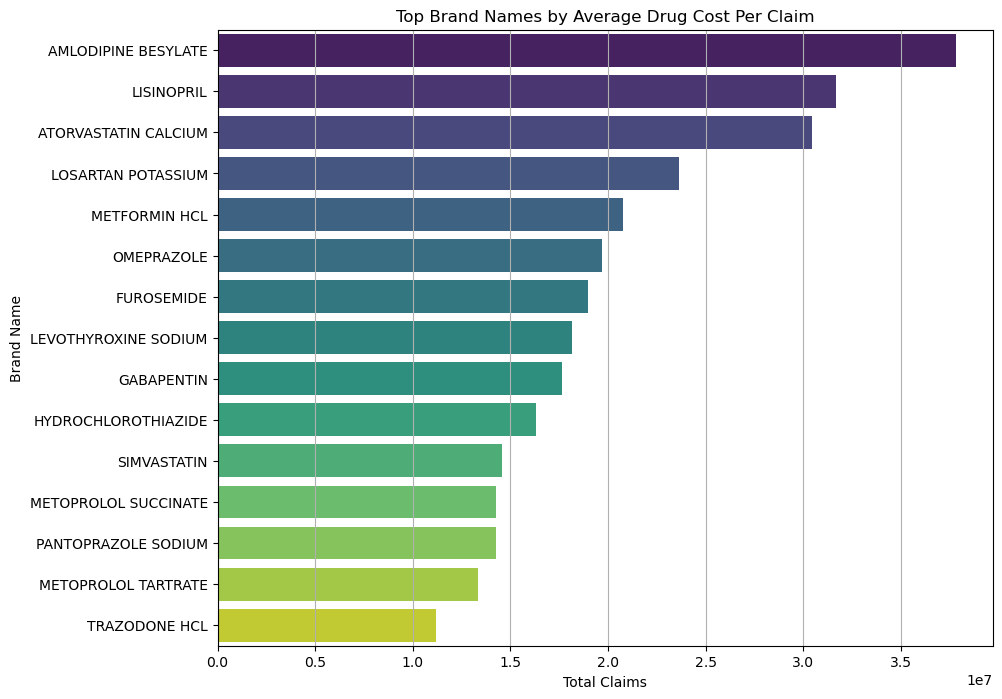

In [203]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Total_Claims', y='Brnd_Name', data=top_drugs_pd, palette='viridis')
plt.title('Top Brand Names by Average Drug Cost Per Claim')
plt.xlabel('Total Claims')
plt.ylabel('Brand Name')
plt.grid(axis='x')

**Insights:**
1. Amlodipine Besylate medication have been claimed most number of times followed by Lisinopril and Atorvastatin Calcium

In [122]:
specialty_cost = mp_df_unique.groupBy("Prscrbr_Type") \
    .agg(F.avg("Drug_Cost_per_Claim").alias("Avg_Cost_Per_Claim")) \
    .orderBy(F.col("Avg_Cost_Per_Claim").desc())

In [123]:
specialty_cost_pd = to_pandas(specialty_cost)

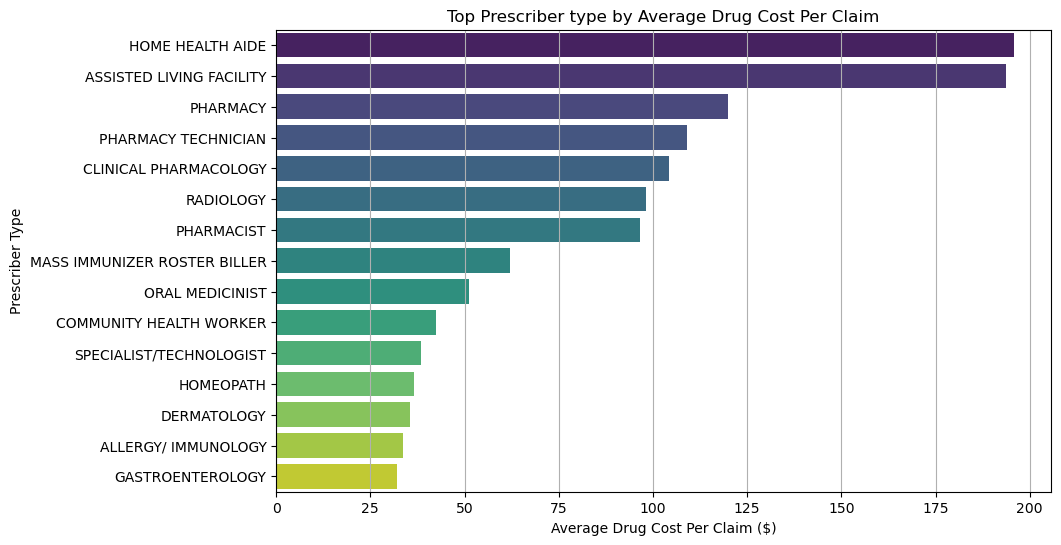

In [130]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Avg_Cost_Per_Claim', y='Prscrbr_Type', data=specialty_cost_pd[:15], palette='viridis')
plt.title('Top Prescriber type by Average Drug Cost Per Claim')
plt.xlabel('Average Drug Cost Per Claim ($)')
plt.ylabel('Prescriber Type')
plt.grid(axis='x')

**Insights:**
1. Prescription type of Home Health Aid and Assisted living Facility have the highest drug cost per claim

**2. 2022 General Payments Data**

In [67]:
# Converting column values to Upper Case for the 2nd dataset
gp_df_unique = gp_df_final
for col_name,dtype in gp_df_final.dtypes:
    if dtype == 'string':
        gp_df_unique = gp_df_unique.withColumn(col_name,F.upper(gp_df_unique[col_name]))

In [69]:
gp_df_unique.columns

['Covered_Recipient_Type',
 'Covered_Recipient_Profile_ID',
 'Covered_Recipient_NPI',
 'Covered_Recipient_First_Name',
 'Covered_Recipient_Last_Name',
 'Recipient_City',
 'Recipient_State',
 'Covered_Recipient_Primary_Type_1',
 'Covered_Recipient_Specialty_1',
 'Covered_Recipient_License_State_code1',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Total_Amount_of_Payment_USDollars',
 'Date_of_Payment',
 'Covered_or_Noncovered_Indicator_1',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Product_Category_or_Therapeutic_Area_1',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1']

In [70]:
# Dropping duplicates
unique_columns_gp = [
    'Covered_Recipient_NPI', 
    'Recipient_City', 
    'Recipient_State',
    'Covered_Recipient_Primary_Type_1',
    'Covered_Recipient_Specialty_1',
    'Date_of_Payment', 
    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
    'Product_Category_or_Therapeutic_Area_1',
    'Total_Amount_of_Payment_USDollars'
]
gp_df_unique = gp_df_unique.dropDuplicates(subset=unique_columns_gp)

In [133]:
top_manufacturers = gp_df_unique.groupBy("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name") \
    .agg(F.sum("Total_Amount_of_Payment_USDollars").alias("Total_Payment")) \
    .orderBy(F.col("Total_Payment").desc())

In [134]:
top_manufacturers_pd = to_pandas(top_manufacturers.limit(15))

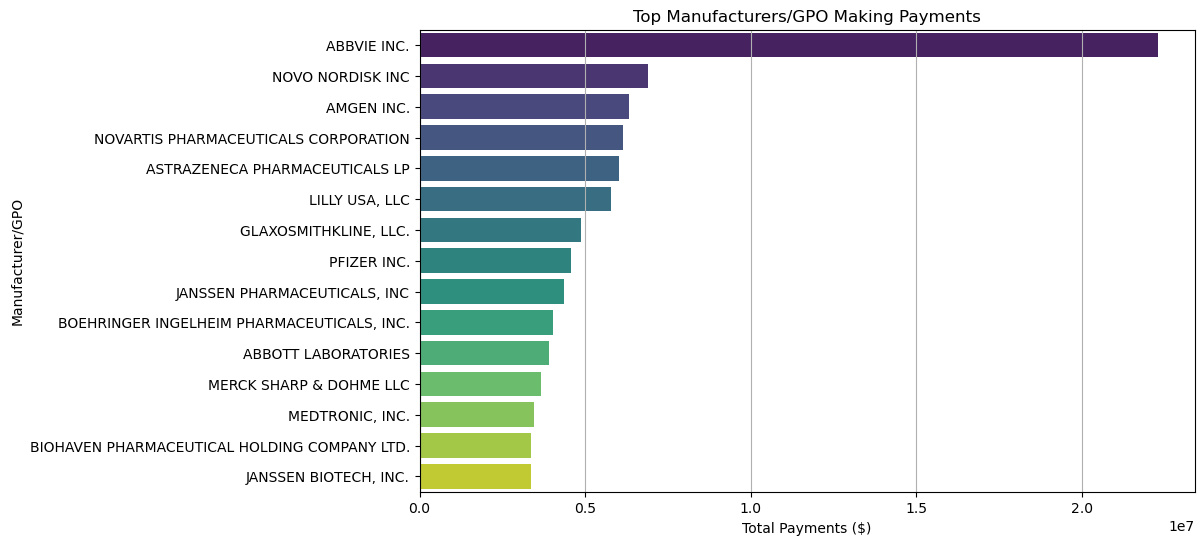

In [136]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Payment', y='Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', data=top_manufacturers_pd, palette='viridis')
plt.title('Top Manufacturers/GPO Making Payments')
plt.xlabel('Total Payments ($)')
plt.ylabel('Manufacturer/GPO')
plt.grid(axis='x')

**Insights**:
1. There are extremely high amount of payments being made by ABBVIE INC. to practicioners

In [138]:
state_payments = gp_df_unique.groupBy("Recipient_State") \
    .agg(F.sum("Total_Amount_of_Payment_USDollars").alias("Total_Payment")) \
    .orderBy(F.col("Total_Payment").desc())

In [139]:
state_payments_pd = to_pandas(state_payments)

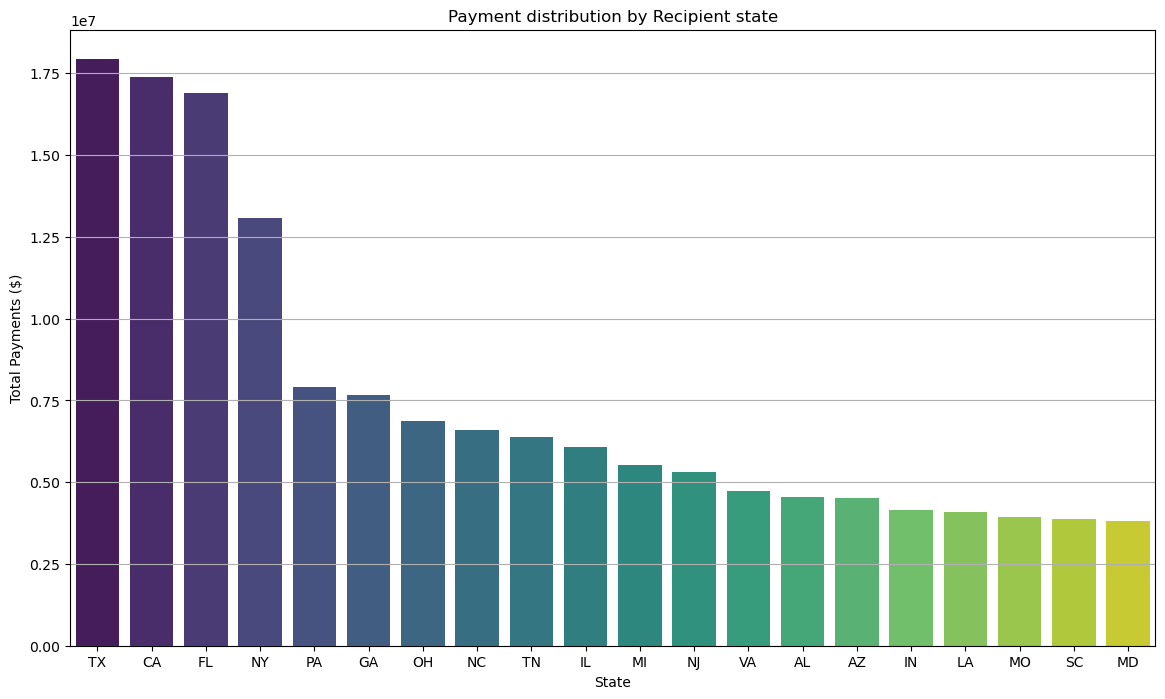

In [201]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Recipient_State', y='Total_Payment', data=state_payments_pd[:20], palette='viridis')
plt.title('Payment distribution by Recipient state')
plt.ylabel('Total Payments ($)')
plt.xlabel('State')
plt.grid(axis='y')

**Insights**
1. Texas, California and Florida recieve the most number of payments from manufacturers/gpo

## Integrating datasets

In [146]:
# the "Prscrbr_NPI" column from Medical Prescription dataset and "Covered_Recipient_NPI" from General Payments dataset
# can be used to combine both the datasets
df = mp_df_unique.join(gp_df_unique, 
                      (mp_df_unique['Prscrbr_NPI'] == gp_df_unique['Covered_Recipient_NPI']) & (mp_df_unique['Prscrbr_State_Abrvtn'] == gp_df_unique['Recipient_State']),
                      "inner")

In [147]:
df.dtypes

[('Prscrbr_NPI', 'int'),
 ('Prscrbr_Last_Org_Name', 'string'),
 ('Prscrbr_First_Name', 'string'),
 ('Prscrbr_City', 'string'),
 ('Prscrbr_State_Abrvtn', 'string'),
 ('Prscrbr_State_FIPS', 'string'),
 ('Prscrbr_Type', 'string'),
 ('Brnd_Name', 'string'),
 ('Gnrc_Name', 'string'),
 ('Tot_Clms', 'int'),
 ('Tot_30day_Fills', 'double'),
 ('Tot_Day_Suply', 'int'),
 ('Tot_Drug_Cst', 'double'),
 ('Tot_Benes', 'int'),
 ('Drug_Cost_per_Claim', 'double'),
 ('Covered_Recipient_Type', 'string'),
 ('Covered_Recipient_Profile_ID', 'int'),
 ('Covered_Recipient_NPI', 'int'),
 ('Covered_Recipient_First_Name', 'string'),
 ('Covered_Recipient_Last_Name', 'string'),
 ('Recipient_City', 'string'),
 ('Recipient_State', 'string'),
 ('Covered_Recipient_Primary_Type_1', 'string'),
 ('Covered_Recipient_Specialty_1', 'string'),
 ('Covered_Recipient_License_State_code1', 'string'),
 ('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'string'),
 ('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_

In [73]:
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
df.columns

['Prscrbr_NPI',
 'Prscrbr_Last_Org_Name',
 'Prscrbr_First_Name',
 'Prscrbr_City',
 'Prscrbr_State_Abrvtn',
 'Prscrbr_State_FIPS',
 'Prscrbr_Type',
 'Brnd_Name',
 'Gnrc_Name',
 'Tot_Clms',
 'Tot_30day_Fills',
 'Tot_Day_Suply',
 'Tot_Drug_Cst',
 'Tot_Benes',
 'Drug_Cost_per_Claim',
 'Covered_Recipient_Type',
 'Covered_Recipient_Profile_ID',
 'Covered_Recipient_NPI',
 'Covered_Recipient_First_Name',
 'Covered_Recipient_Last_Name',
 'Recipient_City',
 'Recipient_State',
 'Covered_Recipient_Primary_Type_1',
 'Covered_Recipient_Specialty_1',
 'Covered_Recipient_License_State_code1',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Total_Amount_of_Payment_USDollars',
 'Date_of_Payment',
 'Covered_or_Noncovered_Indicator_1',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',

In [167]:
# Only selecting columns that are neccessary to derive insights
necc_cols = ['Prscrbr_NPI',
             'Prscrbr_Type',
             'Brnd_Name',
             'Tot_Clms',
             'Tot_Drug_Cst',
             'Tot_Benes',
             'Recipient_State',
             'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
             'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
             'Total_Amount_of_Payment_USDollars',
             'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
             'Drug_Cost_per_Claim']
df_final = df.select(necc_cols)

In [182]:
# Grouping columns for better insights
groupby_cols = ['Prscrbr_NPI',
                'Prscrbr_Type',
                'Brnd_Name',
                'Recipient_State',
                'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name']
df_unique = df_final.groupby(groupby_cols).agg(
    F.sum('Tot_Drug_Cst').alias('Total_Drug_Cost'),
    F.sum('Total_Amount_of_Payment_USDollars').alias('Total_Payments_gp'), 
    F.sum('Tot_Clms').alias('Total_Claims')
)

In [183]:
df_unique.columns

['Prscrbr_NPI',
 'Prscrbr_Type',
 'Brnd_Name',
 'Recipient_State',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Total_Drug_Cost',
 'Total_Payments_gp',
 'Total_Claims']

In [184]:
df_unique.count()

46841838

In [185]:
Brand_Precription_and_Payments = df_unique.groupby(['Brnd_Name']) \
    .agg(F.sum('Total_Claims').alias("Total_Claims"),F.sum('Total_Payments_gp').alias('Total_payments')) \
    .orderBy(F.desc("Total_payments"))

In [186]:
Brand_Precription_and_Payments_by_Drug_cost_pandas = to_pandas(Brand_Precription_and_Payments.limit(20))

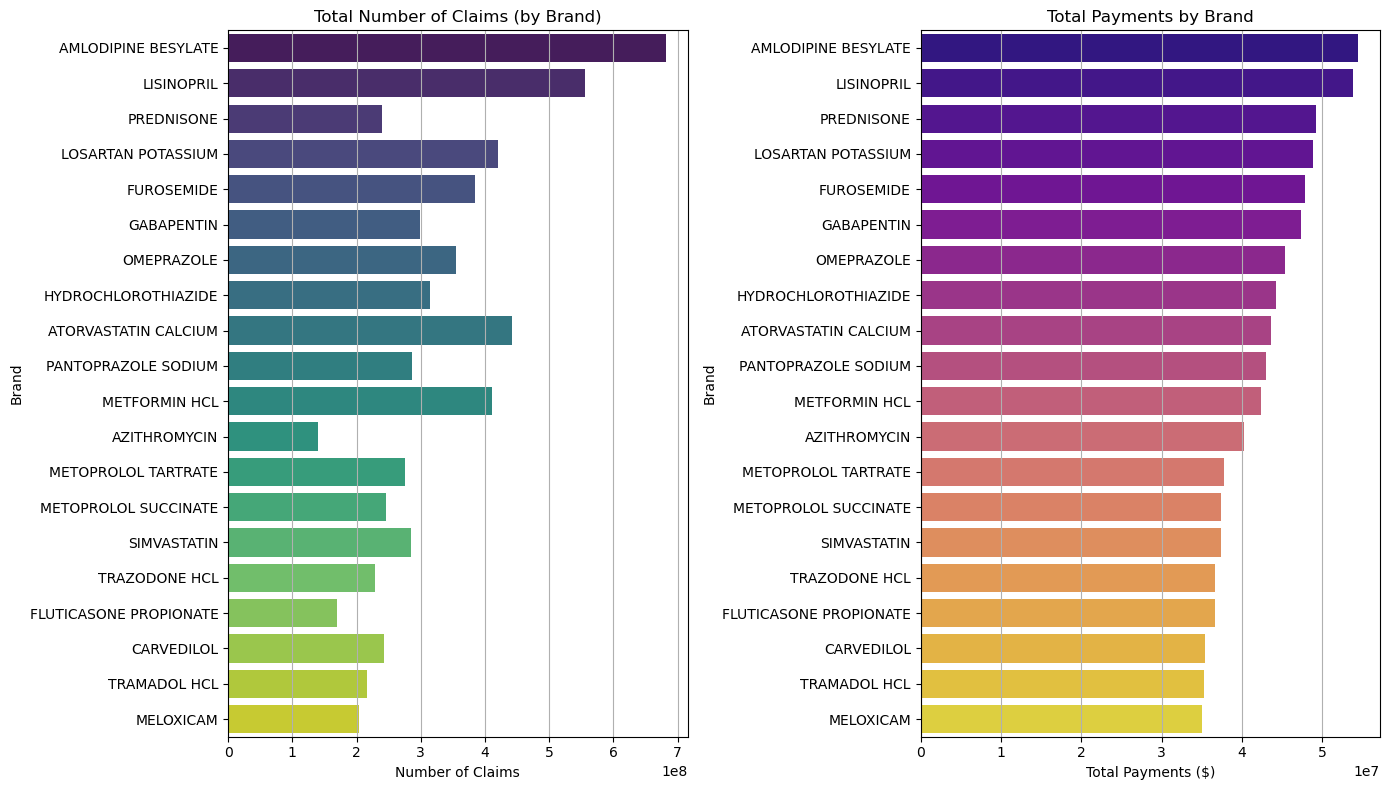

In [196]:
plt.figure(figsize=(14, 8))


plt.subplot(1, 2, 1)
sns.barplot(x='Total_Claims', y='Brnd_Name', data=Brand_Precription_and_Payments_by_Drug_cost_pandas, palette='viridis')
plt.title('Total Number of Claims (by Brand)')
plt.xlabel('Number of Claims')
plt.ylabel('Brand')
plt.grid(axis='x')


plt.subplot(1, 2, 2)
sns.barplot(x='Total_payments', y='Brnd_Name', data=Brand_Precription_and_Payments_by_Drug_cost_pandas, palette='plasma')
plt.title('Total Payments by Brand')
plt.xlabel('Total Payments ($)')
plt.ylabel('Brand')
plt.grid(axis='x')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Insights:**
1. High payments from Amlodipine brand to practicioners with high claims of the same brand medication infer that prescriptions precribed by practitioners may be influenced by the financial payments.

In [189]:
top_manufacturers_prescribers = df_unique.groupBy("Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name") \
    .agg(F.sum("Total_Claims").alias("Total_Claims"), 
         F.sum("Total_Payments_gp").alias("Total_Payment")) \
    .orderBy(F.col("Total_Payment").desc())

In [190]:
top_manufacturers_prescribers_pd = to_pandas(top_manufacturers_prescribers)

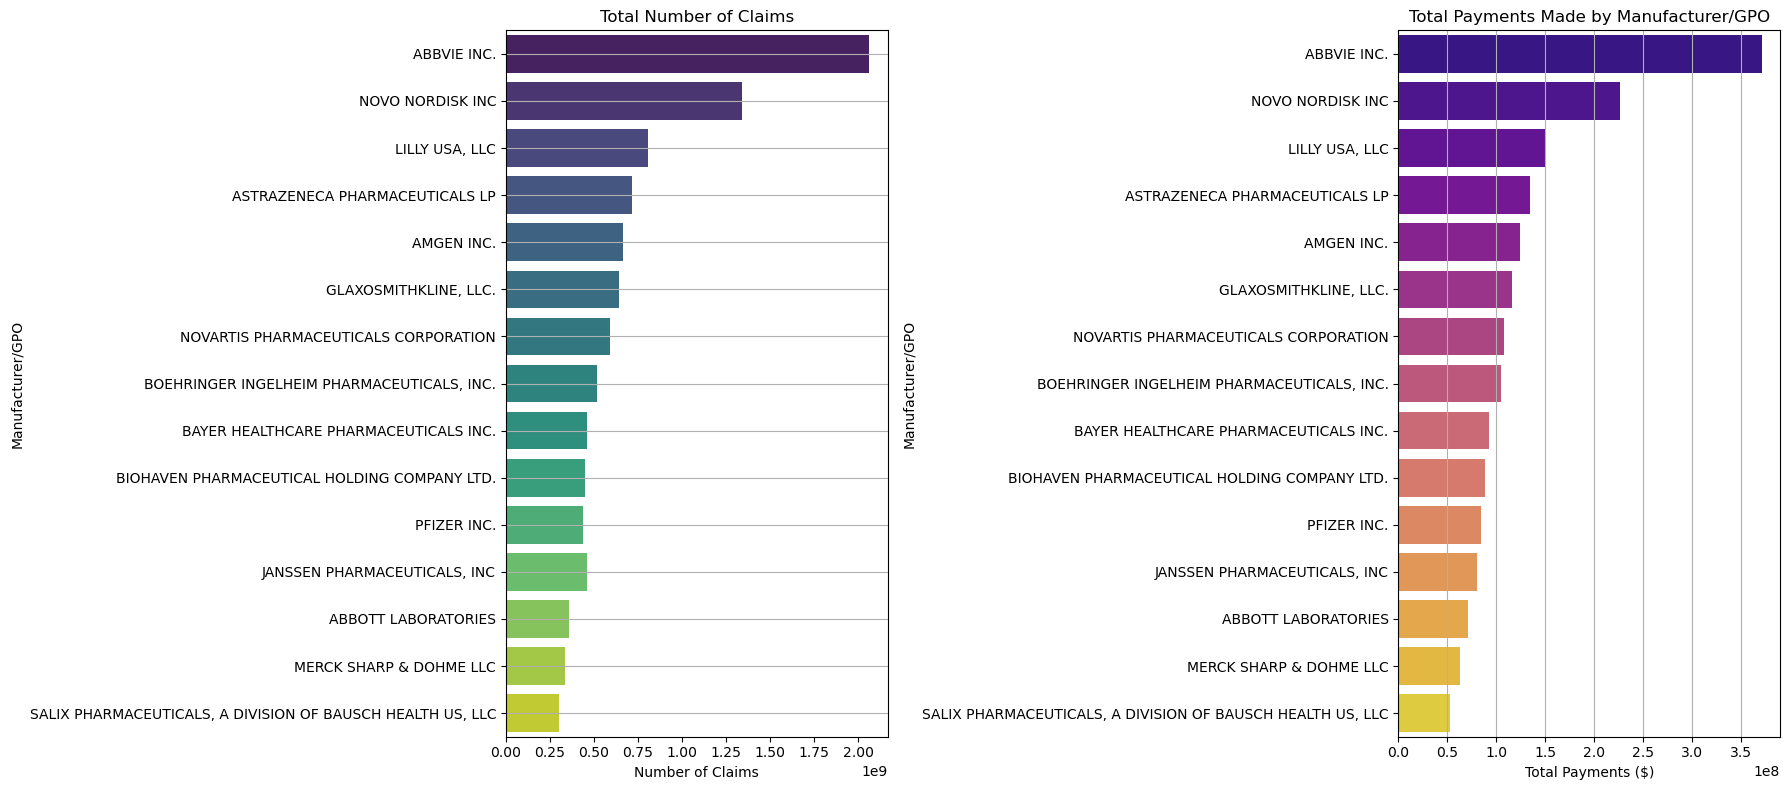

In [194]:
plt.figure(figsize=(18, 8))


plt.subplot(1, 2, 1)
sns.barplot(x='Total_Claims', y='Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', data=top_manufacturers_prescribers_pd[:15], palette='viridis')
plt.title('Total Number of Claims')
plt.xlabel('Number of Claims')
plt.ylabel('Manufacturer/GPO')
plt.grid(axis='y')


plt.subplot(1, 2, 2)
sns.barplot(x='Total_Payment', y='Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', data=top_manufacturers_prescribers_pd[:15], palette='plasma')
plt.title('Total Payments Made by Manufacturer/GPO')
plt.xlabel('Total Payments ($)')
plt.ylabel('Manufacturer/GPO')
plt.grid(axis='x')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Insight:**
1. There is a clear correlation between number of claims and total payments by the manufacturer/gpo